# Instalando as libs


In [ ]:
pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-tnqj26ph
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-tnqj26ph
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 2.7 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=6ccff5df86cdbb23572c1f8edda40a501c87ce04b8639faaf7682ed4a4d1afa3
  Stored in directory: /tmp/pip-ephem-wheel-cache-q0ymujg9/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


# Importando libs 

In [304]:
from segmentation_models.losses import bce_jaccard_loss
from sklearn.model_selection import train_test_split 
from segmentation_models import get_preprocessing
from segmentation_models.metrics import iou_score
from keras.layers import Input, Conv2D
from segmentation_models import Unet
from imagem_carrega import carregar 
import segmentation_models as sm
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

# Leitura dos dados e pré - processamento

In [267]:
imgs_np, masks_np = carregar('whales/*.png')
x = np.asarray(imgs_np, dtype = np.float32)/255.0
y = np.asarray(masks_np, dtype = np.float32) 

print(f'Antes do reshape: {x.shape}, {y.shape}')

y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)

print(f'Depois do reshape: {x.shape}, {y.shape}')

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.05, random_state = 0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val:   ", x_val.shape)
print("y_val:   ", y_val.shape)

Carregando: 100%|#######################| 148/148 [00:01<00:00, 97.82it/s]


Antes do reshape: (148, 384, 384, 3), (148, 384, 384)
Depois do reshape: (148, 384, 384, 3), (148, 384, 384, 1)
x_train:  (140, 384, 384, 3)
y_train:  (140, 384, 384, 1)
x_val:    (8, 384, 384, 3)
y_val:    (8, 384, 384, 1)


In [268]:
x_train[0].shape

(384, 384, 3)

In [269]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

x_train = preprocess_input(x_train)
x_val   = preprocess_input(x_val)

# define model
model = Unet(BACKBONE, encoder_weights='imagenet', input_shape = x_train[0].shape)

model.compile('Adam', loss = bce_jaccard_loss, metrics=[iou_score])

In [270]:
%%time 
# fit model
historico = model.fit(
            x = x_train,
            y = y_train,
            batch_size = 10,
            epochs = 50,
            validation_data=(x_val, y_val))

Epoch 1/50
14/14 [==============================] - 10s 422ms/step - loss: 0.9873 - iou_score: 0.3532 - val_loss: 12.0465 - val_iou_score: 0.1651
Epoch 2/50
14/14 [==============================] - 5s 369ms/step - loss: 0.5156 - iou_score: 0.6105 - val_loss: 3.6811 - val_iou_score: 0.1776
Epoch 3/50
14/14 [==============================] - 5s 372ms/step - loss: 0.3482 - iou_score: 0.7334 - val_loss: 2.6134 - val_iou_score: 0.1327
Epoch 4/50
14/14 [==============================] - 5s 369ms/step - loss: 0.2733 - iou_score: 0.7977 - val_loss: 3.0287 - val_iou_score: 0.0823
Epoch 5/50
14/14 [==============================] - 5s 366ms/step - loss: 0.2244 - iou_score: 0.8376 - val_loss: 1.8391 - val_iou_score: 0.0593
Epoch 6/50
14/14 [==============================] - 5s 364ms/step - loss: 0.1617 - iou_score: 0.8806 - val_loss: 1.5985 - val_iou_score: 0.0355
Epoch 7/50
14/14 [==============================] - 5s 362ms/step - loss: 0.1449 - iou_score: 0.8943 - val_loss: 1.6388 - val_iou_scor

In [271]:
y_pred = model.predict(x_val)

In [272]:
zer = np.zeros((384, 384, 2))
imag   = []
titles = []
for i in range(8):
  
  imag.append(x_val[i])
  titles.append('Imagem Original')
  saida = np.concatenate((y_val[i], zer), axis = 2)
  imag.append(saida) 
  titles.append('Máscara Original')
  saida = np.concatenate((y_pred[i], zer), axis = 2)
  imag.append(saida) 
  titles.append('Previsão')

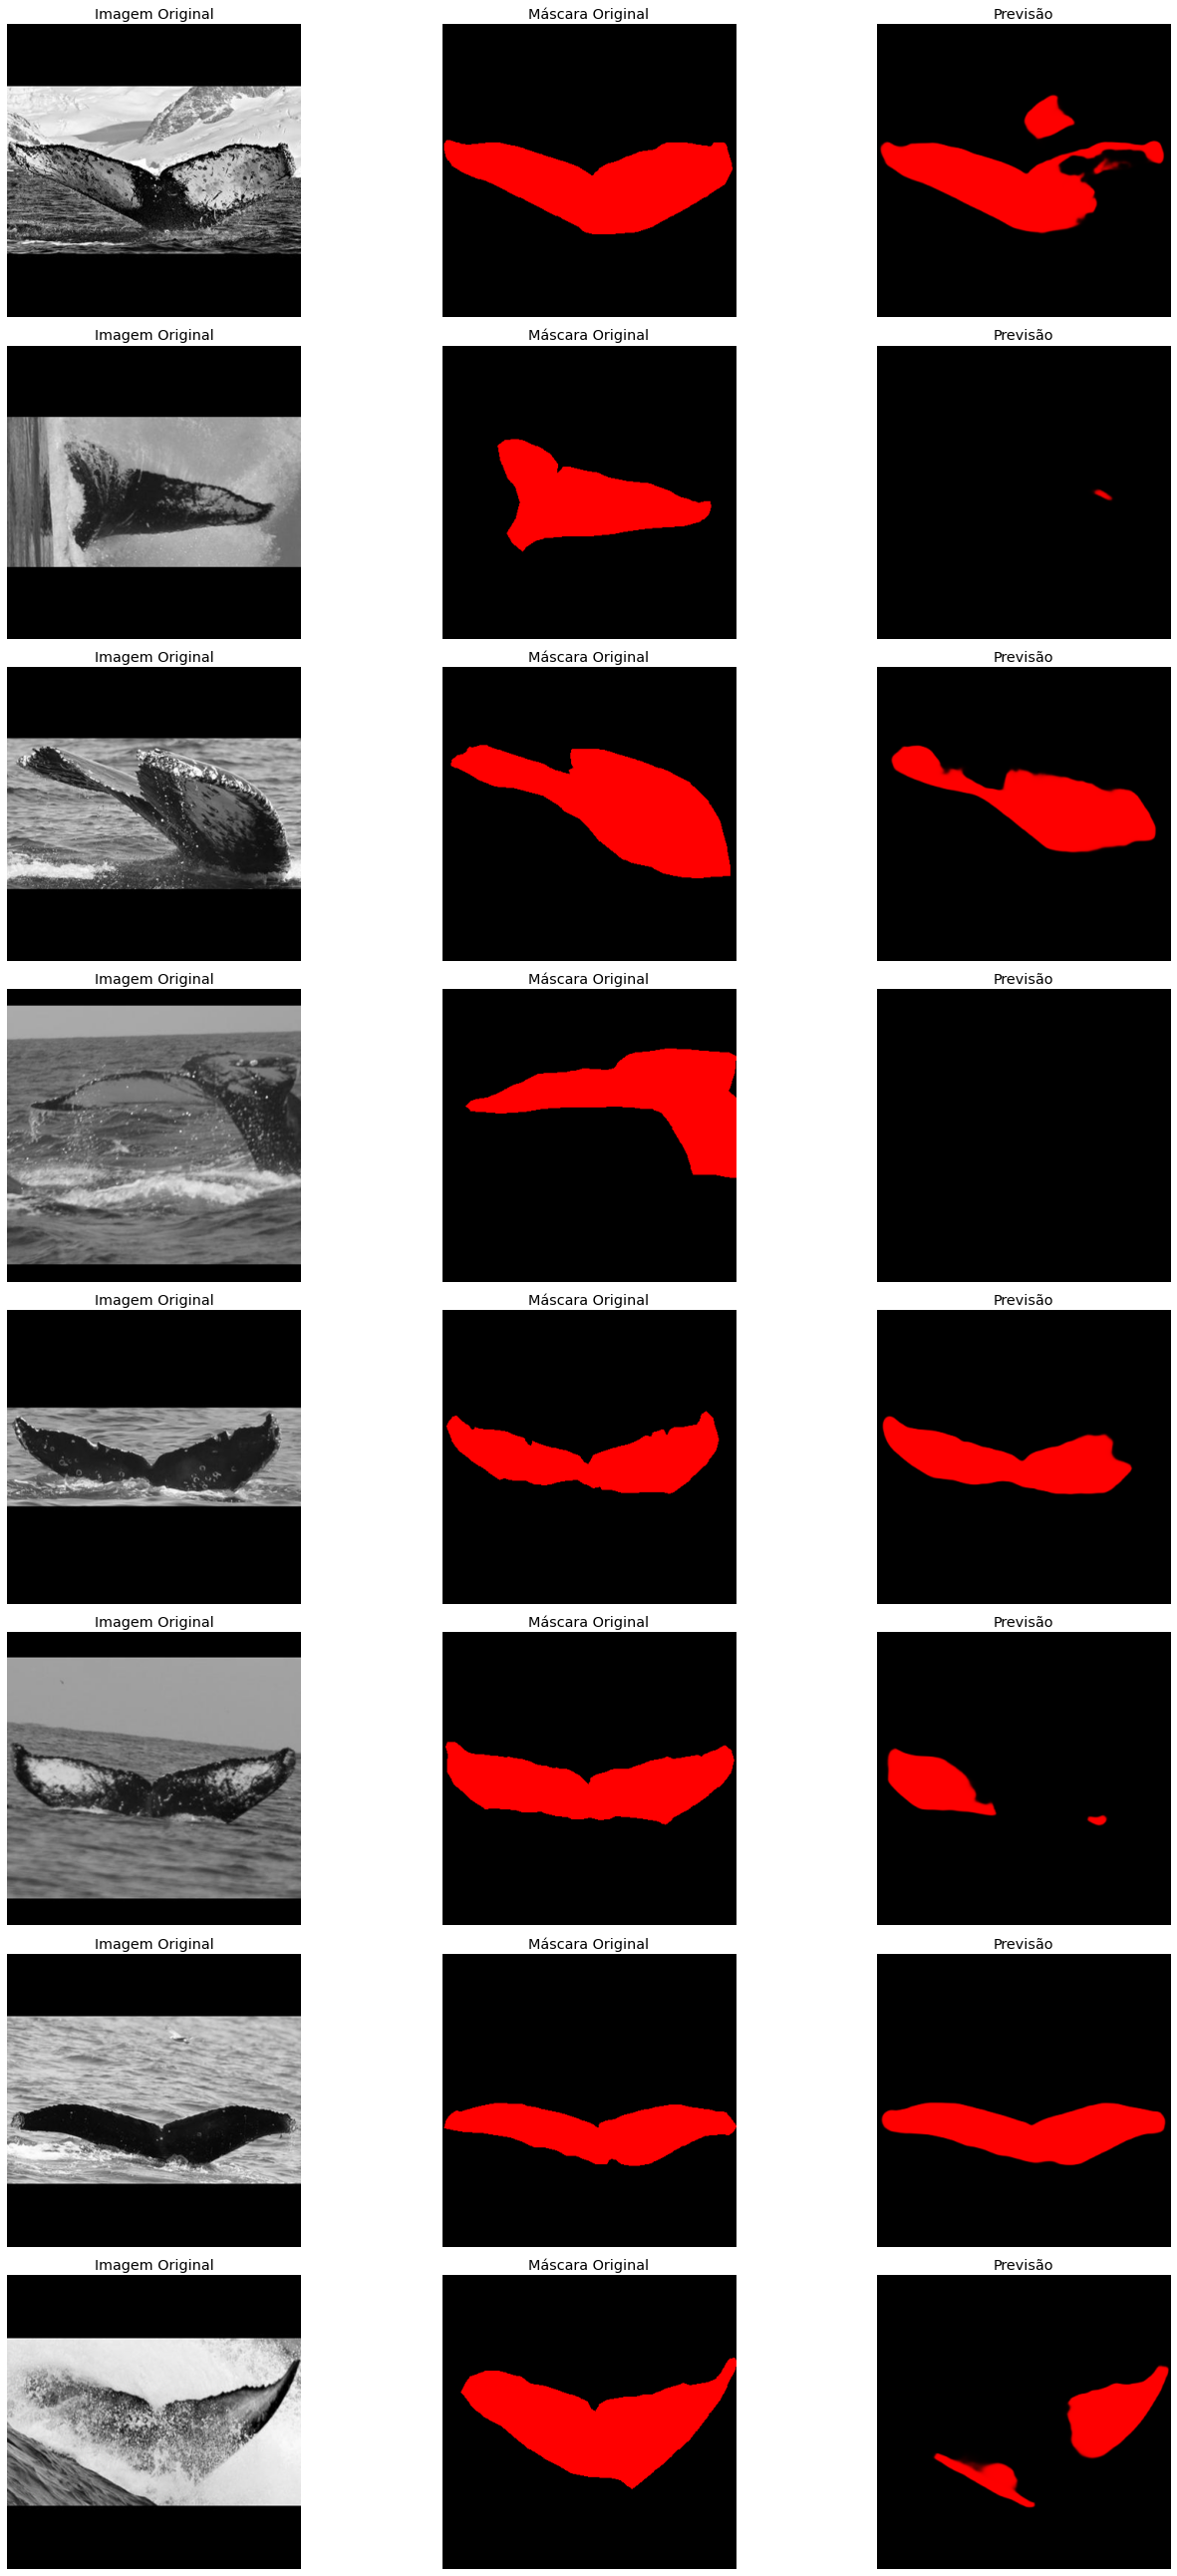

In [273]:
rows = 8
cols = 3
axes = []

fig = plt.figure(figsize = (20, 1.5*rows*cols))
for i in range(rows*cols):
    axes.append(fig.add_subplot(rows, cols, i+1) )
    axes[-1].set_title(titles[i])  
    axes[-1].set_axis_off()
    plt.imshow(imag[i])
    

fig.tight_layout()    
plt.show()

In [274]:
dados = historico.history

In [275]:
val_iou_score = dados['val_iou_score']
iou_score     = dados['iou_score']
loss          = dados['loss']
val_loss      = dados['val_loss']

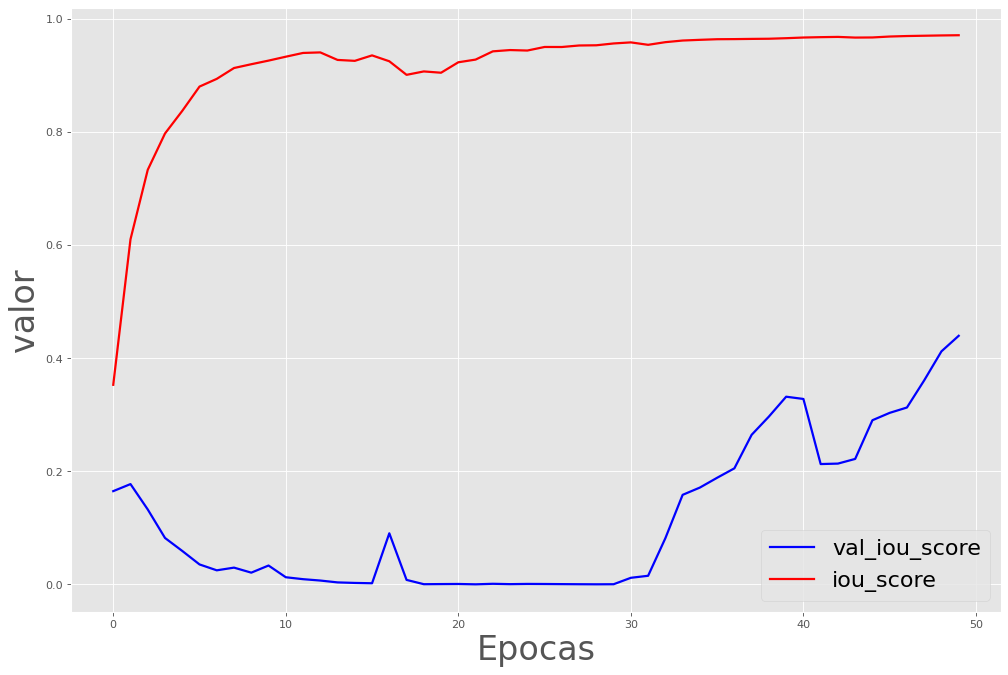

In [276]:
plt.style.use('ggplot') 
plt.figure(figsize=(15, 10), dpi = 80)  
plt.plot(val_iou_score, lw = 2.0, label = 'val_iou_score', color = 'blue')
plt.plot(iou_score, lw = 2.0, label = 'iou_score', color = 'red') 
plt.xlabel('Epocas',fontsize = 30)  
plt.ylabel('valor', fontsize = 30) 
plt.legend(fontsize=20)
plt.show()

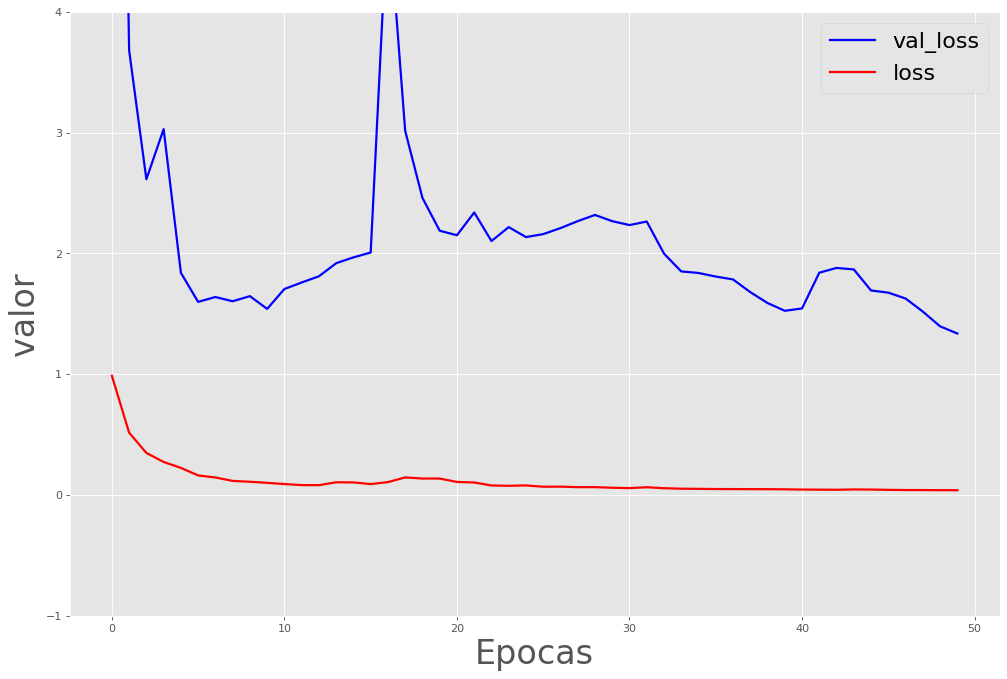

In [277]:
plt.figure(figsize=(15, 10), dpi = 80)  
plt.plot(val_loss, lw = 2.0, label = 'val_loss', color = 'blue')
plt.plot(loss, lw = 2.0, label = 'loss', color = 'red') 
plt.xlabel('Epocas',fontsize = 30)  
plt.ylabel('valor', fontsize = 30) 
plt.legend(fontsize=20)
plt.ylim([-1,4])
plt.show()

In [367]:
from PIL import Image
import glob
import os
import sys

masks = glob.glob("label/*.png")
orgs  = glob.glob("image/*.png")

imgs_list  = []
masks_list = []

for image, mask in zip(orgs, masks):
    imgs_list.append(np.array(Image.open(image).resize((512,512))))
    im = Image.open(mask).resize((512,512))
    masks_list.append(np.array(im))

imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_np, dtype=np.float32)/255

y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)

x_train2, x_val2, y_train2, y_val2 = train_test_split(x, y, test_size=0.1, random_state=0)

print("x_train: ", x_train2.shape)
print("y_train: ", y_train2.shape)
print("x_val: ", x_val2.shape)
print("y_val: ", y_val2.shape)

x_train:  (27, 512, 512, 1)
y_train:  (27, 512, 512, 1)
x_val:  (3, 512, 512, 1)
y_val:  (3, 512, 512, 1)


In [368]:
N = x.shape[-1]

base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model2 = Model(inp, out, name=base_model.name)

In [369]:
model2.compile('Adam', loss = bce_jaccard_loss, metrics=[iou_score])

In [381]:
historico2 = model2.fit(
            x = x_train2,
            y = y_train2,
            batch_size = 9,
            epochs = 300,
            validation_data=(x_val2, y_val2))

Epoch 1/300
3/3 [==============================] - 12s 998ms/step - loss: 0.0366 - iou_score: 0.9842 - val_loss: 1.9348 - val_iou_score: 0.7920
Epoch 2/300
3/3 [==============================] - 2s 606ms/step - loss: 0.0352 - iou_score: 0.9846 - val_loss: 1.9320 - val_iou_score: 0.7920
Epoch 3/300
3/3 [==============================] - 2s 606ms/step - loss: 0.0330 - iou_score: 0.9853 - val_loss: 1.9309 - val_iou_score: 0.7920
Epoch 4/300
3/3 [==============================] - 2s 614ms/step - loss: 0.0313 - iou_score: 0.9859 - val_loss: 1.9345 - val_iou_score: 0.7920
Epoch 5/300
3/3 [==============================] - 2s 607ms/step - loss: 0.0297 - iou_score: 0.9865 - val_loss: 1.9424 - val_iou_score: 0.7920
Epoch 6/300
3/3 [==============================] - 2s 606ms/step - loss: 0.0282 - iou_score: 0.9870 - val_loss: 1.9453 - val_iou_score: 0.7920
Epoch 7/300
3/3 [==============================] - 2s 603ms/step - loss: 0.0275 - iou_score: 0.9873 - val_loss: 1.9483 - val_iou_score: 0.792

In [423]:
y_pred2 = model2.predict(x_val2)

In [426]:
imag   = []
titles = []
for i in range(3):
  saida = x_val2[i]
  imag.append(saida[:,:,0])
  titles.append('Imagem Original')
  saida = y_val2[i]
  imag.append(saida[:,:,0])
  titles.append('Máscara Original')
  saida = y_pred2[i]
  imag.append(saida[:,:,0])
  titles.append('Previsão')

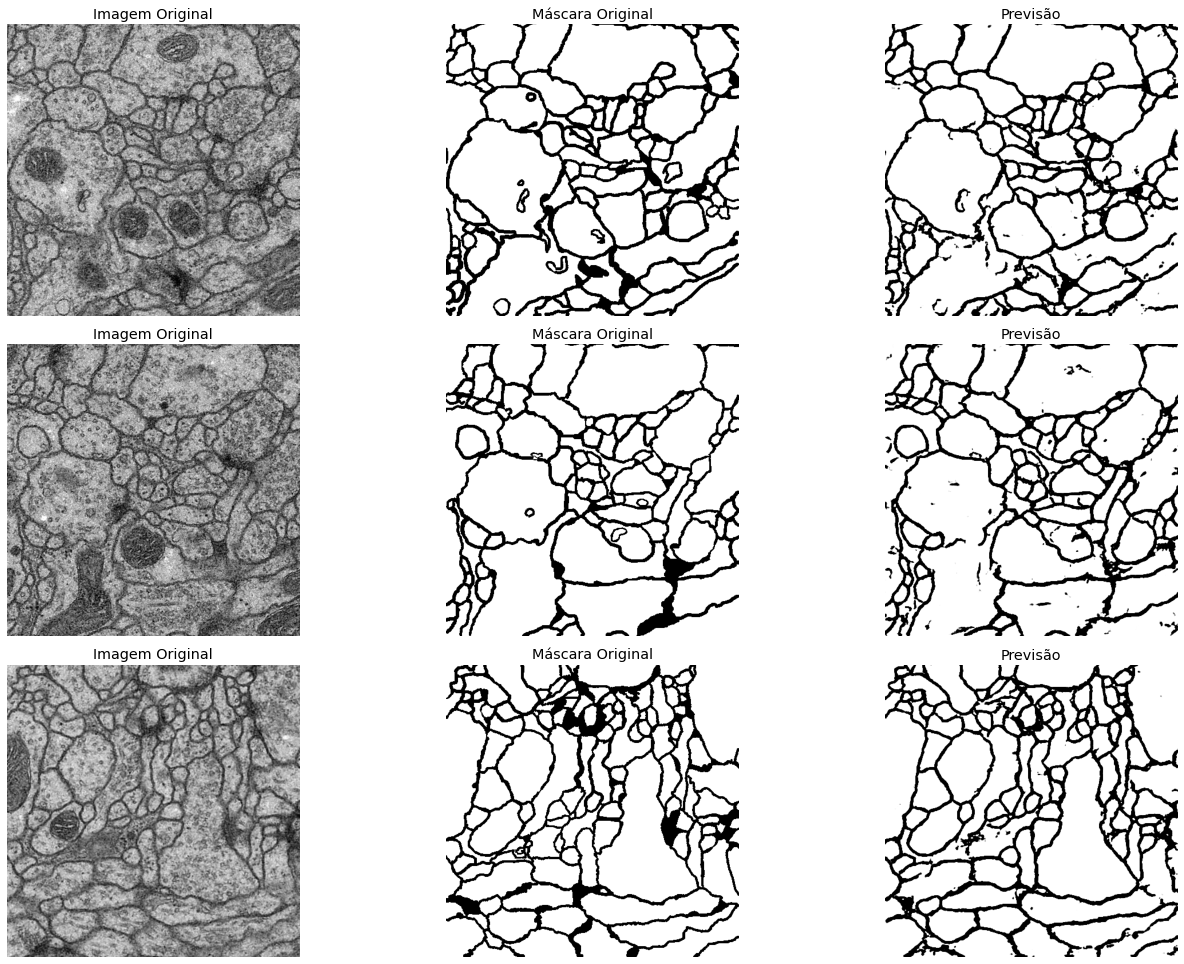

In [427]:
rows = 3
cols = 3
axes = []

fig = plt.figure(figsize = (20, 1.5*rows*cols))
for i in range(rows*cols):
    axes.append(fig.add_subplot(rows, cols, i+1) )
    axes[-1].set_title(titles[i])  
    axes[-1].set_axis_off()
    plt.imshow(imag[i], cmap = plt.get_cmap("gray"))
    

fig.tight_layout()    
plt.show()

In [428]:
dados = historico2.history
val_iou_score = dados['val_iou_score']
iou_score     = dados['iou_score']
loss          = dados['loss']
val_loss      = dados['val_loss']

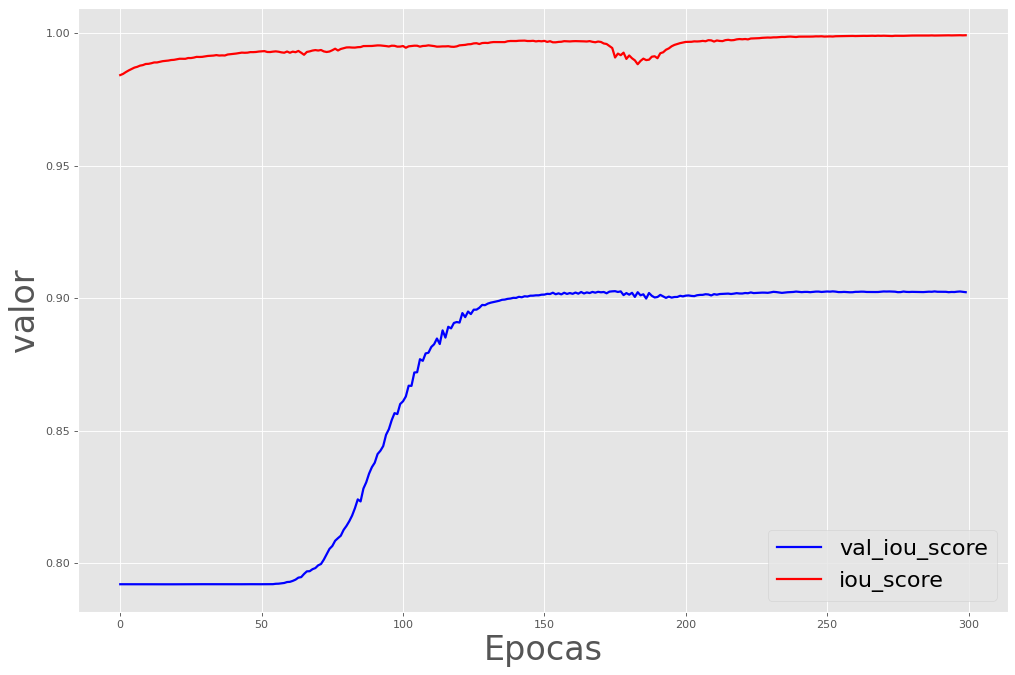

In [429]:
plt.style.use('ggplot') 
plt.figure(figsize=(15, 10), dpi = 80)  
plt.plot(val_iou_score, lw = 2.0, label = 'val_iou_score', color = 'blue')
plt.plot(iou_score, lw = 2.0, label = 'iou_score', color = 'red') 
plt.xlabel('Epocas',fontsize = 30)  
plt.ylabel('valor', fontsize = 30) 
plt.legend(fontsize=20)
plt.show()

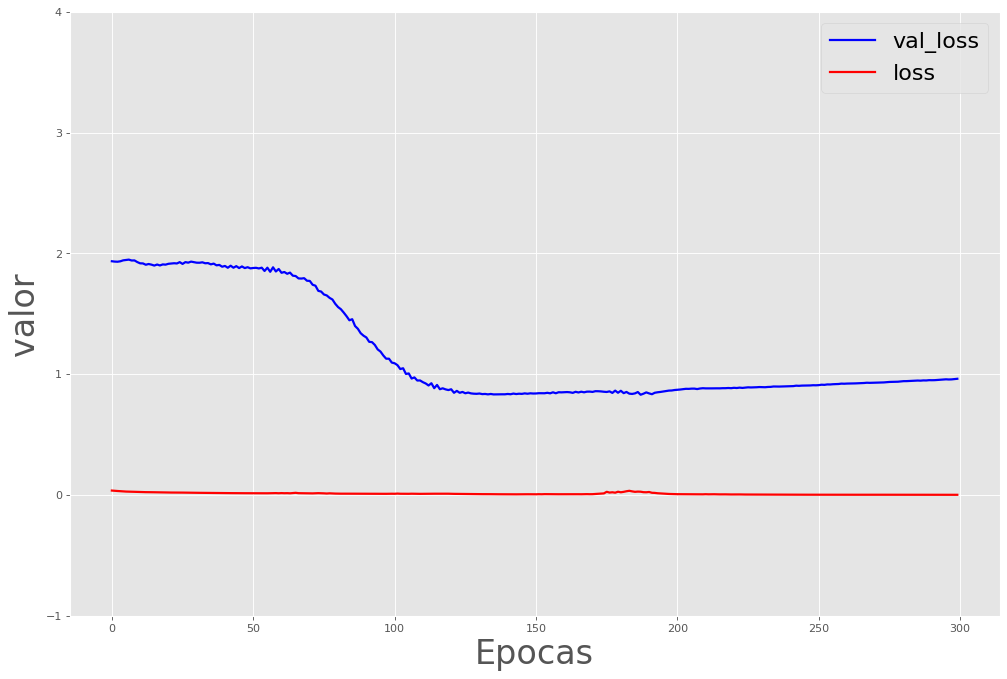

In [430]:
plt.figure(figsize=(15, 10), dpi = 80)  
plt.plot(val_loss, lw = 2.0, label = 'val_loss', color = 'blue')
plt.plot(loss, lw = 2.0, label = 'loss', color = 'red') 
plt.xlabel('Epocas',fontsize = 30)  
plt.ylabel('valor', fontsize = 30) 
plt.legend(fontsize=20)
plt.ylim([-1,4])
plt.show()